## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import random
from PIL import Image
from itertools import chain
from random import sample
import tensorflow as tf
from skimage import io
import scipy
import sklearn.model_selection as skl
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
108997,00029596_019.png,Effusion,19,29596,34,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029596_019.png
27806,00007239_000.png,No Finding,0,7239,52,F,PA,2500,2048,0.168000,0.168000,NaN,/data/images_004/images/00007239_000.png
102950,00027441_023.png,Effusion|Pneumothorax,23,27441,11,F,AP,2508,2516,0.139000,0.139000,NaN,/data/images_011/images/00027441_023.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

## Split "Finding Labels" column into one column per disease, with a binary flag.
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
91939,00022936_000.png,No Finding,0,22936,30,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91000,00022680_003.png,No Finding,3,22680,83,F,PA,2470,2457,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
95354,00025064_000.png,No Finding,0,25064,61,F,PA,2754,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df = all_xray_df.rename(columns={'Pneumonia': 'pneumonia_class'})
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,pneumonia_class,Pneumothorax
88046,00021782_013.png,No Finding,13,21782,35,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105445,00028341_006.png,Consolidation|Effusion,6,28341,10,M,AP,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49552,00012576_024.png,Effusion|Infiltration,24,12576,59,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [5]:
def create_splits(test_size, df, stratify_class):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[stratify_class])

    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(0.2, all_xray_df, 'pneumonia_class')

train_data['pneumonia_class'].sum()/len(train_data)

0.012765340706386016

In [7]:
val_data['pneumonia_class'].sum()/len(val_data)

0.012754191937210132

In [8]:
## Ensure equal proportions of pneumonia and no pneumonia in training data set
p_inds = train_data[train_data.pneumonia_class==1].index.tolist()
np_inds = train_data[train_data.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [9]:
train_data['pneumonia_class'].sum()/len(train_data)

0.5

In [10]:
## Ensure representative proportions of pneumonia and no pneumonia in validation data set
## Recall that pneumonia was 0.01276 and no pneumonia 0.9872 of the data set
## In this case, I'll use 20% and 80% respectively, to ensure adequate samples

np_to_p = int(0.8/0.2)

p_inds = val_data[val_data.pneumonia_class==1].index.tolist()
np_inds = val_data[val_data.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,np_to_p*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]

In [11]:
val_data['pneumonia_class'].sum()/len(val_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False,
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(df, xcol, ycol, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                    directory=None, 
                                    x_col = xcol,
                                    y_col = ycol,
                                    class_mode = 'raw',
                                    target_size = img_size, 
                                    batch_size = batch_size
                                    )
    
    return train_gen


def make_val_gen(df, xcol, ycol, img_size, batch_size):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=df, 
                                directory=None, 
                                x_col = xcol,
                                y_col = ycol,
                                class_mode = 'raw',
                                target_size = img_size, 
                                batch_size = batch_size
                                )
    
    return val_gen

In [13]:
## Perform image augmentation on the data
img_size=(224, 224)
batch_size = 64

train_gen = make_train_gen(train_data, 'path', 'pneumonia_class', img_size, batch_size)
val_gen = make_val_gen(val_data, 'path', 'pneumonia_class', img_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

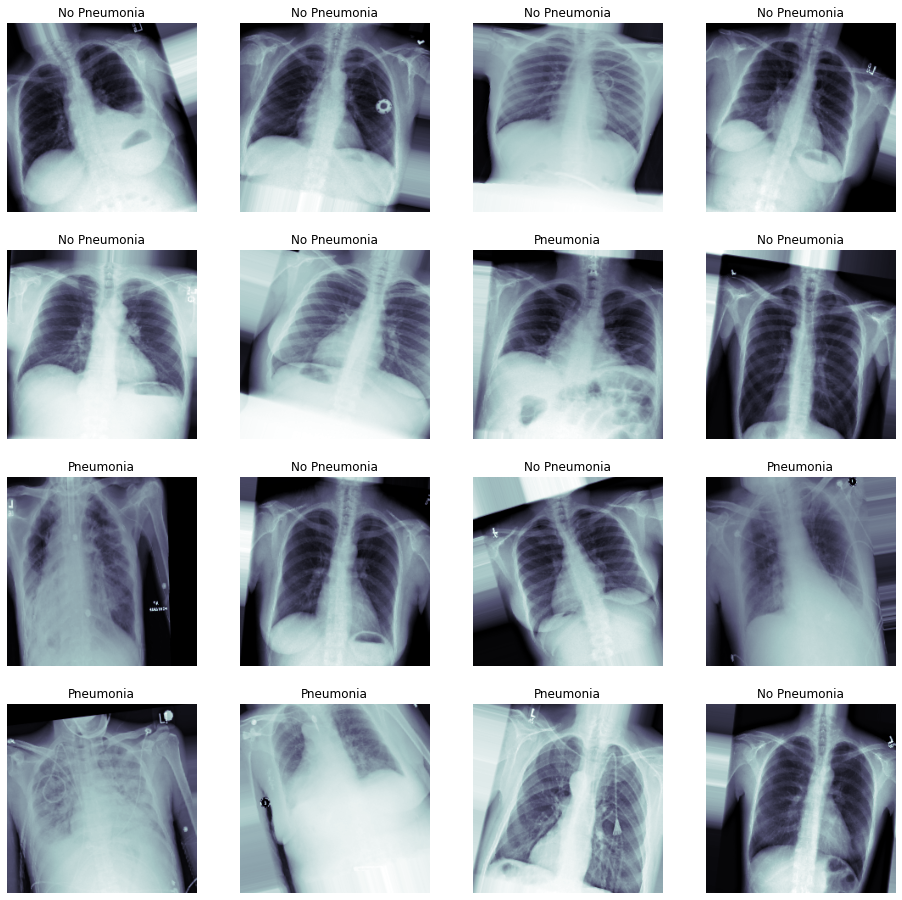

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
 
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    return vgg_model


In [27]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    vgg_model = load_pretrained_model()
    my_model.add(vgg_model)

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))

    return my_model

my_model = build_my_model()
my_model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [31]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

# Set our optimizer, loss function, and metrics to monitor (learning rate)
optimizer = Adam(learning_rate=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

# Compile model
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 61s 2s/step - loss: 6.4681 - binary_accuracy: 0.3930 - val_loss: 3.1338 - val_binary_accuracy: 0.7969

Epoch 00001: val_loss did not improve from 3.13319
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 6.5232 - binary_accuracy: 0.3934 - val_loss: 3.1333 - val_binary_accuracy: 0.7969

Epoch 00002: val_loss did not improve from 3.13319
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 6.3167 - binary_accuracy: 0.3900 - val_loss: 3.1332 - val_binary_accuracy: 0.7969

Epoch 00003: val_loss did not improve from 3.13319
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 6.3860 - binary_accuracy: 0.3987 - val_loss: 3.1333 - val_binary_accuracy: 0.7969

Epoch 00004: val_loss did not improve from 3.13319
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 6.4612 - binary_accuracy: 0.3895 - val_loss: 3.1338 - val_binary_accuracy: 0.7969

Epoch 00005: val_loss

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [21]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return

# def ...
# Todo
def plot_f1_thresh(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1_score = calc_f1(precision, recall)
    f1_score = f1_score[:-1]
    c_ax.plot(thresholds, f1_score, label = '%s (F1 Score:)'% ('Pneumonia'))
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Score')
    return
        
def  calc_f1(prec,recall):   
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


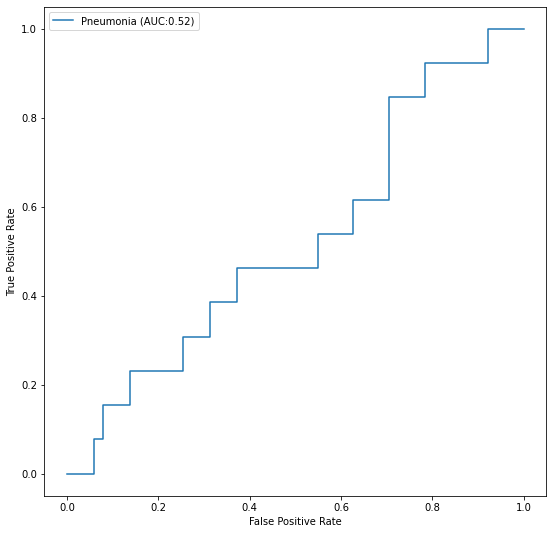

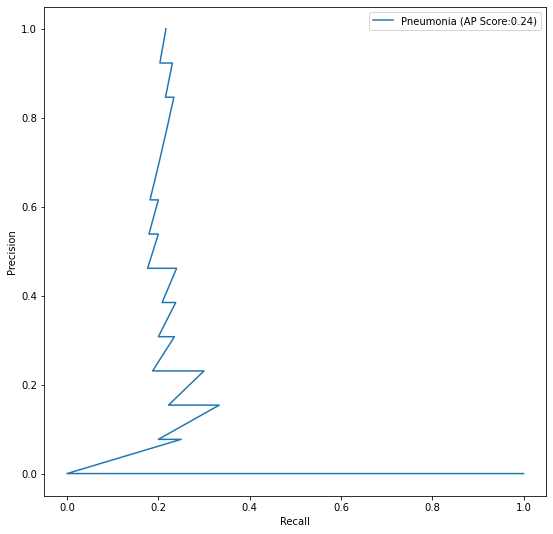

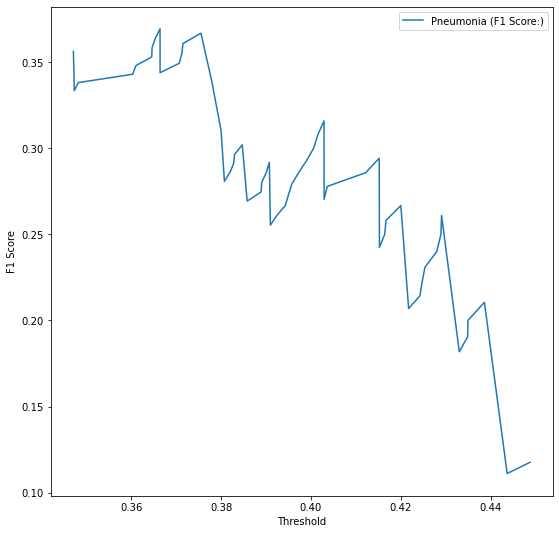

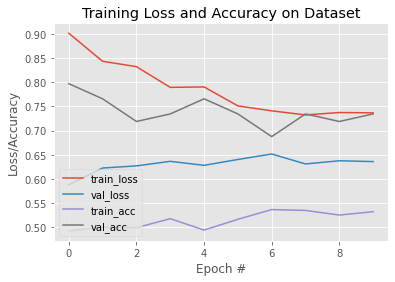

In [22]:
## plot figures

# Todo
# Plotting AUC
plot_auc(valY, pred_Y)

# Plotting Precision-Recall
plot_pr(valY, pred_Y)

# Plotting F1-Threshold
plot_f1_thresh(valY, pred_Y)

# Plotting History
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = f1_score(valY, (pred_Y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))

thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.33766233766233766
F1 score at threshold 0.11 is 0.33766233766233766
F1 score at threshold 0.12 is 0.33766233766233766
F1 score at threshold 0.13 is 0.33766233766233766
F1 score at threshold 0.14 is 0.33766233766233766
F1 score at threshold 0.15 is 0.33766233766233766
F1 score at threshold 0.16 is 0.33766233766233766
F1 score at threshold 0.17 is 0.33766233766233766
F1 score at threshold 0.18 is 0.33766233766233766
F1 score at threshold 0.19 is 0.33766233766233766
F1 score at threshold 0.2 is 0.33766233766233766
F1 score at threshold 0.21 is 0.33766233766233766
F1 score at threshold 0.22 is 0.33766233766233766
F1 score at threshold 0.23 is 0.33766233766233766
F1 score at threshold 0.24 is 0.33766233766233766
F1 score at threshold 0.25 is 0.33766233766233766
F1 score at threshold 0.26 is 0.33766233766233766
F1 score at threshold 0.27 is 0.33766233766233766
F1 score at threshold 0.28 is 0.33766233766233766
F1 score at threshold 0.29 is 0.33766233766233766
F1

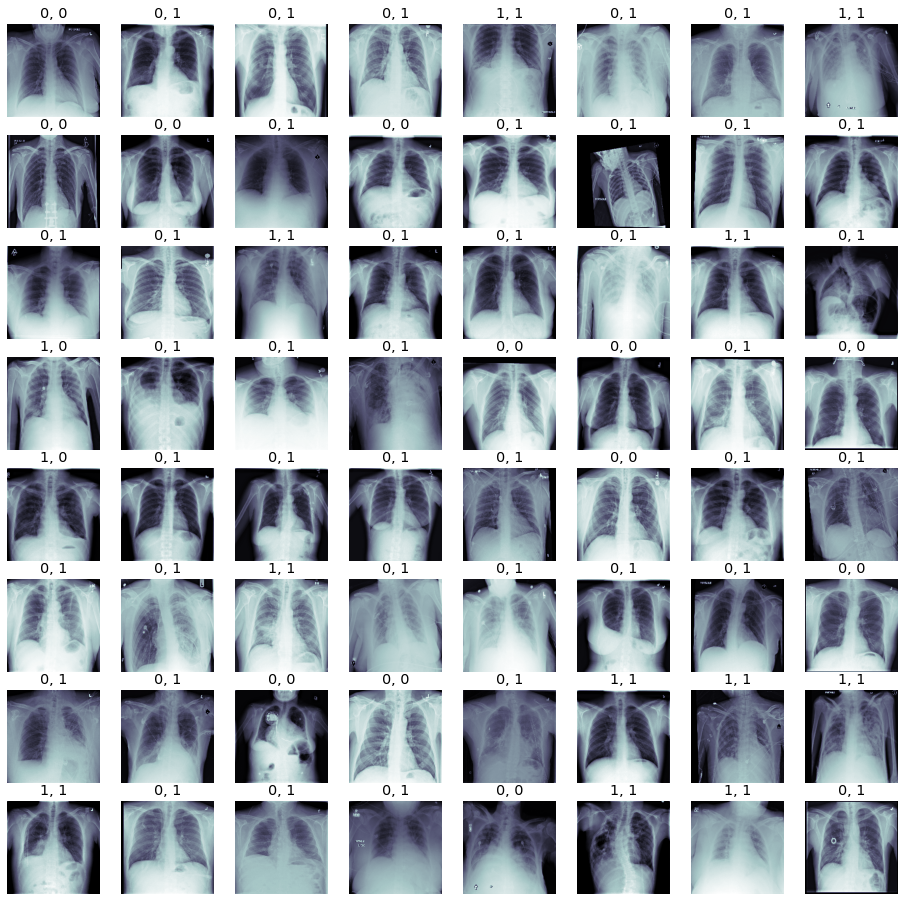

In [24]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [25]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)